In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

2023-12-09 13:46:42.421253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Wrangling

In [2]:
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2

In [3]:
base_dir = '/Users/sabitabaral/Documents/Springboard/capstone3/Data'
target_width, target_height = 100, 100
batch_size = 10
for data_type in os.listdir(base_dir):
    data_type_path = os.path.join(base_dir, data_type)
    
    # Ensure it's a directory (not a system file)
    if os.path.isdir(data_type_path) and not data_type.startswith('.'):
        # Loop through each class in the data type
        for class_name in os.listdir(data_type_path):
            class_path = os.path.join(data_type_path, class_name)
            
            # Ensure it's a directory (not a system file)
            if os.path.isdir(class_path) and not class_name.startswith('.'):
                # Loop through each file in the class
                for filename in os.listdir(class_path):
                    filepath = os.path.join(class_path, filename)

                    # Check if it's a file (not a subdirectory)
                    if os.path.isfile(filepath):
                        # Read the image
                        img = cv2.imread(filepath)

                        # Resize the image
                        img_resized = cv2.resize(img, (target_width, target_height))
                        # Save or overwrite the resized image
                        cv2.imwrite(filepath, img_resized)

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create generators for training, validation, and test sets
train_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(target_width, target_height),
    batch_size=batch_size,
    class_mode='categorical',  # Since you have multiple classes
    subset='training'  # Specify 'training' for the training set
)

Found 491 images belonging to 4 classes.


In [5]:
validation_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=(target_width, target_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify 'validation' for the validation set
)

test_generator = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(target_width, target_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test set
)

Found 13 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [13]:
## Classes are not very balanced. Let's evaluate calss weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming you have class_names and class_counts
class_names = list(class_counts.keys())
class_weights = compute_class_weight('balanced', class_names, train_generator.classes)

# Convert to a dictionary for Keras model training
class_weights_dict = dict(zip(range(len(class_names)), class_weights))

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

## Exploratory Data Analysis

In [10]:
from PIL import Image
import random

In [11]:
def display_random_images(data_path, classes, num_images=3):
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, num_images)

        plt.figure(figsize=(10, 4))
        for i, image_file in enumerate(random_images, 1):
            image_path = os.path.join(class_path, image_file)
            img = Image.open(image_path)
            
            plt.subplot(1, num_images, i)
            plt.imshow(img)
            plt.title(f'{class_name} - {i}')
            plt.axis('off')
        plt.show()

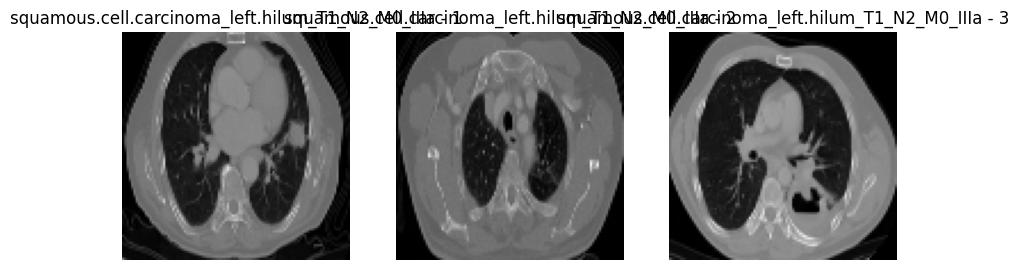

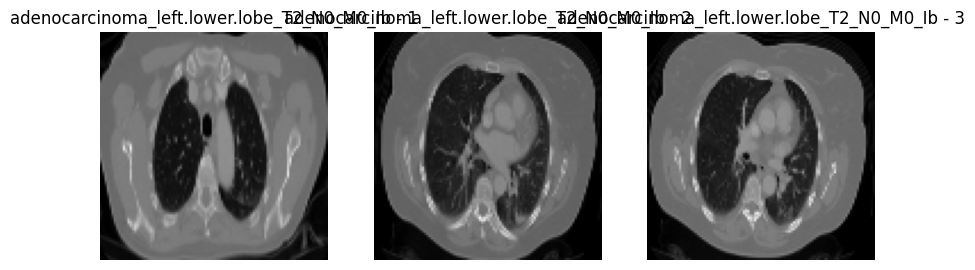

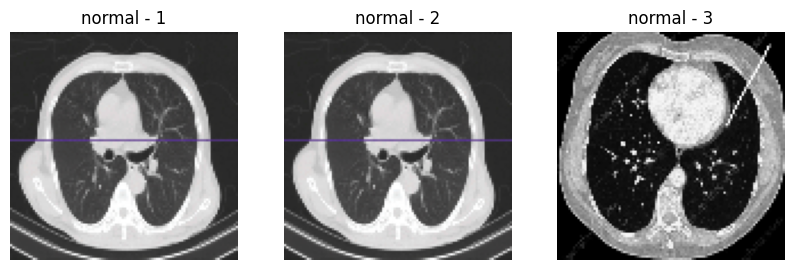

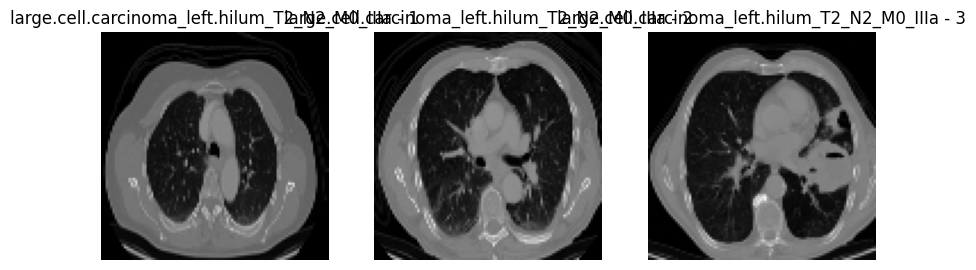

In [12]:
classes = os.listdir(train_data_path)
display_random_images(train_data_path, classes)

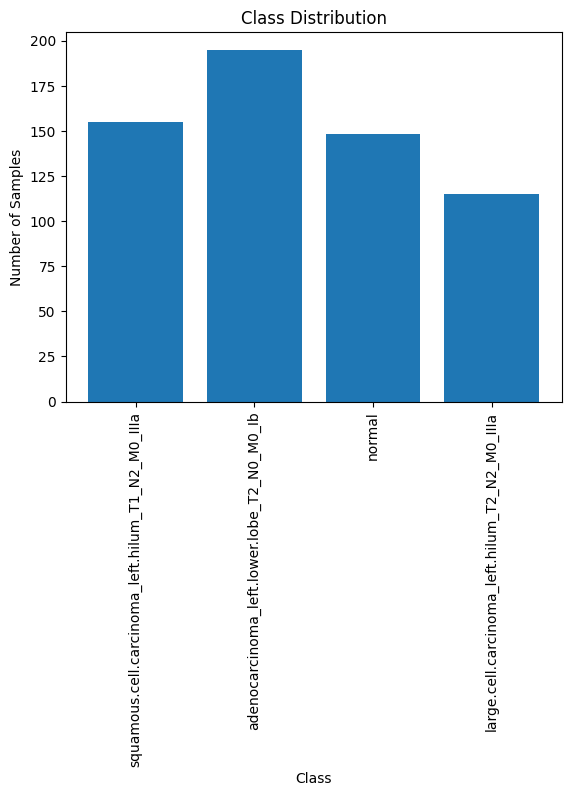

In [15]:
## see class distribution
class_counts = {class_name: len(os.listdir(os.path.join(train_data_path, class_name))) for class_name in classes}
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()

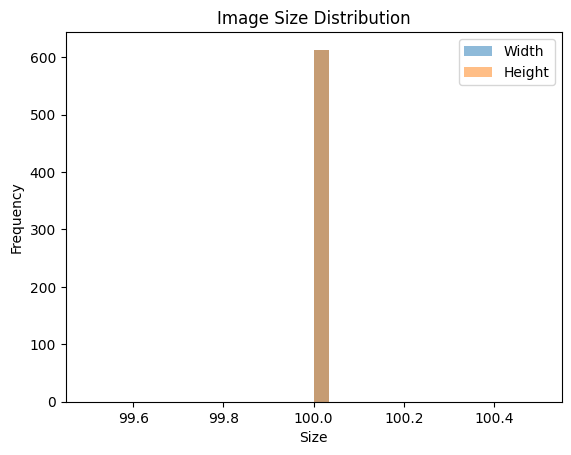

In [16]:
## Image size distribution
def get_image_sizes(data_path, classes):
    sizes = []
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = Image.open(image_path)
            sizes.append(img.size)
    return sizes

# Get image sizes
image_sizes = get_image_sizes(train_data_path, classes)

# Plot histograms of image sizes
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=30, alpha=0.5, label='Width')
plt.hist(heights, bins=30, alpha=0.5, label='Height')
plt.legend()
plt.title('Image Size Distribution')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()

#### All images has same size, which is good

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 3, 8, 7, 3, 5, 3, 0, 2, 10, 18, 23, 21, 19, 20, 19, 7, 1, 0, 3, 16, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 13, 18, 11, 3, 4, 6, 7, 3, 1, 0, 1, 2, 4, 9, 17, 21, 6, 4, 17, 13, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 4, 20, 20, 20, 20, 21, 18, 22, 20, 19, 19, 16, 6, 4, 9, 9, 4, 5, 21, 21, 20, 23, 17, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 2, 1, 3, 9, 13, 17, 20, 19, 21, 21, 20, 19, 10, 8, 1, 0, 0, 0, 6, 22, 15, 1, 19, 17, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 18, 23, 23, 8, 6, 5, 1, 4, 5, 4, 3, 8, 6, 11, 20, 19, 13, 2, 0, 2, 4, 8, 8, 4, 1, 0, 0, 0, 1, 4, 6, 12, 18, 17, 17, 17, 12, 18, 23, 17, 15, 14, 11, 3, 3, 4, 4, 10, 17, 17, 18, 16, 7, 0, 0, 3, 17, 17, 2, 12, 20, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

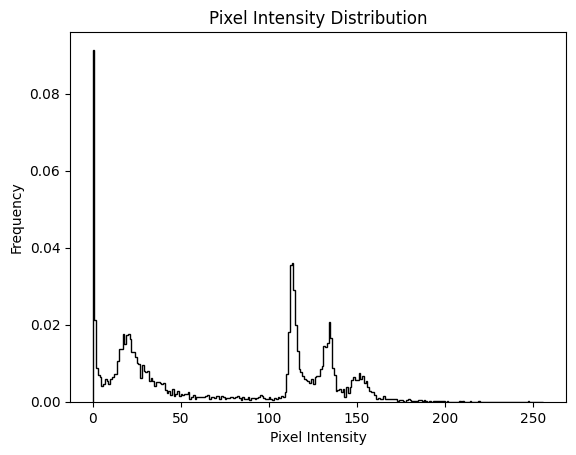

In [27]:
## pixel indensity distribution
from PIL import Image
def get_pixel_intensities(image):
    # Convert the image to grayscale if it's in color
    if image.mode != 'L':
        image = image.convert('L')

    # Get pixel intensities
    intensities = list(image.getdata())
    
    return intensities

# Example usage:
class_path = os.path.join(train_data_path, class_name)
image_file = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_file)
img = Image.open(image_path)

pixel_intensities = get_pixel_intensities(img)
print(pixel_intensities)

# Plot histogram of pixel intensities
plt.hist(pixel_intensities, bins=256, range=(0, 256), density=True, histtype='step', color='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [36]:
print(img.mode)

RGB


In [37]:
img.split()

(<PIL.Image.Image image mode=L size=100x100>,
 <PIL.Image.Image image mode=L size=100x100>,
 <PIL.Image.Image image mode=L size=100x100>)

### Looks like images are grayscale